This notebook esimates FFH using YOLO object detection results from GSV pano images and corresponding depth maps, and conducts assessment of results using ground-truth data.

## Load modules
* Functions on geometry restoration are contained in the geometry.py module.

In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import numpy as np
import os
import glob
from PIL import Image
from geometry import extract_feature_pixels_lowest_region, calculate_height_difference, estimate_FFH, estimate_FFE
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from tqdm import tqdm
import pandas as pd

## Set input file of object detection results, folder of depth images and ground-truth building points

In [94]:
# # Wagga
# predictions_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\GSV\Wagga\YOLO_test\prediction\object_detection_results.csv'
# in_folder_depth=r'D:\Wagga\GSV\Depth_clipped'
# building_point_file=r'D:\Wagga\GSV\Final_Wagga_meta_camera_height_ground_elevations_gapfill_depth.geojson'

In [95]:
# Launceston
predictions_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\GSV\Launceston\YOLO_test\prediction\object_detection_results.csv'
in_folder_depth=r'D:\Launceston\GSV\Depth_clipped'
building_point_file=r'D:\Launceston\GSV\LC_Final_meta_camera_height_ground_elevations_gapfill_depth.geojson'

## Read in ground-truth data

In [96]:
gdf=gpd.read_file(building_point_file)
gdf.head()

,EASTING,NORTHING,UFI,ZONE,DEM,LID,ADDRESS,SUBURB,POSTCODE,FEATURE_NA,...,roll,elevation,date,height_c,grd_elev_GSV,grd_elev_building_min,grd_elev_building_mean,grd_elev_building_max,gapfilling_depth,geometry
0,510962.988188,5.412541e+06,1002,15.0 Urban Mixed Use,2.697813,GNAF_GATAS702308914,13 PARK STREET,LAUNCESTON,7250,None,...,6.228637,5.546635,2019-10,2.298505,2.697813,2.32000,2.718059,3.013333,17.298815,POINT (16378573.381 -5077255.621)
1,511021.688427,5.412248e+06,33,11.0 Inner Residential,4.208417,GNAF_GATAS702204375,293 BRISBANE STREET,LAUNCESTON,7250,None,...,6.235322,5.922997,2023-09,2.547754,4.208417,4.18531,4.789202,5.885000,30.437919,POINT (16378652.195 -5077648.094)
2,511082.136711,5.412226e+06,31,11.0 Inner Residential,4.540370,GNAF_GATAS702478623,4 MIDDLE STREET,LAUNCESTON,7250,None,...,0.022607,7.156610,2023-09,2.427306,4.540370,4.10874,4.491268,4.910000,3.164598,POINT (16378732.79 -5077677.2)
3,511068.760790,5.412219e+06,28,11.0 Inner Residential,5.212643,GNAF_GATAS702296648,6 MIDDLE STREET,LAUNCESTON,7250,None,...,0.010492,7.739836,2023-09,2.578520,5.212643,3.88800,4.751154,5.595274,4.880474,POINT (16378714.979 -5077685.813)
4,511048.726805,5.412229e+06,26,11.0 Inner Residential,5.162260,GNAF_GATAS702290011,8 MIDDLE STREET,LAUNCESTON,7250,None,...,0.021449,8.384348,2023-09,2.563187,5.162260,4.53000,5.015464,5.865000,33.696933,POINT (16378688.262 -5077672.596)


## Read in object detection results and depth maps

In [97]:
df_predictions = pd.read_csv(predictions_file)
df_predictions.head()

,image,class,confidence,top,bottom,pano_id,x1,y1,x2,y2
0,NaN,front door,0.362740,NaN,NaN,YNLZF16ubLTqrzW7SkVC3A,2494.0,2040.0,2589.0,2260.0
1,NaN,front door,0.886357,NaN,NaN,Tz6NjkiBNSG1ge0lKjXhdg,1824.0,2141.0,1934.0,2385.0
2,NaN,foundation,0.306104,NaN,NaN,kC4sWh0ZUf1E7nz52Fb9xA,1567.0,2789.0,1964.0,2837.0
3,NaN,garage door,0.433893,NaN,NaN,GvP_WNzTHiz53PaBhohUcw,15.0,1887.0,346.0,2520.0
4,NaN,front door,0.502356,NaN,NaN,yUC9VsjcbhJLP9IhkcS9NA,1814.0,2143.0,1978.0,2415.0


In [98]:
classes=["foundation", "front door", "garage door", "stairs"]
coords_cols=['x1','y1','x2','y2']
# Group by image and class to find the bounding box with the highest y2 (bottom most)
lowest_features = (
    df_predictions.loc[df_predictions.groupby(['pano_id', 'class'])['y2'].idxmax()]
    .reset_index(drop=True)
)
# Create a dictionary with (x1, y1) tuples for each class per image
results = {}
for pano, group in lowest_features.groupby('pano_id'):
    # Initialize a dictionary for the image with None for all classes
    class_coords = {cls: None for cls in classes}
    # Update with the actual (x1, y1) coordinates for existing classes
    for _, row in group.iterrows():
        class_coords[row['class']] = {col: int(row[col]) for col in coords_cols}
    # Store results as a list of tuples (x1, y1) in the final dictionary
    results[pano] = [class_coords[cls] for cls in classes]

In [99]:
pano_id,coords=list(results.items())[0]
print(pano_id)

--peTCkMWNfwDvhe3fjLKQ


In [100]:
pano_id='_0w_LRrd4G5vqZX3sFuJwA'
coords=results[pano_id]

In [101]:
depth_file=os.path.join(in_folder_depth,pano_id+'.tif')
depth_arr=np.asarray(Image.open(depth_file))
H_img = depth_arr.shape[0]  # Height of the cropped panorama

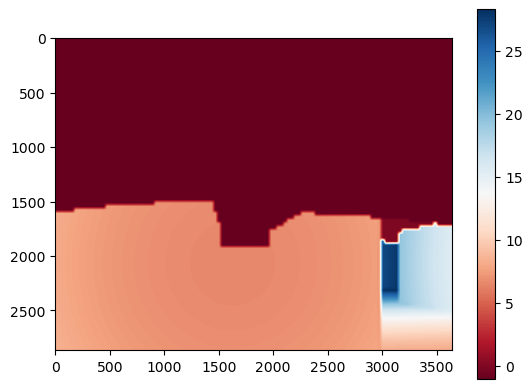

In [102]:
fig, ax = plt.subplots()
im=ax.imshow(depth_arr,cmap='RdBu', interpolation='none')
fig.colorbar(im)

## Extract building ground elevation, roadway elevation and camera height

In [103]:
building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_mean'].values[0]
road_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_GSV'].values[0]
height_camera=gdf.loc[gdf['pano_id'] == pano_id, 'height_c'].values[0]

In [104]:
building_elevation

1.2682005

In [105]:
road_elevation

1.3038048

In [106]:
height_camera

2.244783639907837

In [107]:
# extract camera elevation from GSV metadata
# elev_camera=gdf.loc[gdf['pano_id'] == pano_id, 'elevation'].values[0]
# print(elev_camera)
elev_camera=height_camera+road_elevation

### Extract gapfilling depth

In [108]:
depth_gapfill=gdf.loc[gdf['pano_id'] == pano_id, 'gapfilling_depth'].values[0]
depth_gapfill

17.24870044210966

## FFH/FFE Estimation
### Extract feature top/bottom pixels for each class

In [109]:
# extract bottom pixels of foundation, stairs, front door and garage door
foundation_bottom_pixels = {(coords[0]['x1'],coords[0]['y2']),(coords[0]['x2'],coords[0]['y2'])} if coords[0] is not None else None
frontdoor_bottom_pixels = {(coords[1]['x1'],coords[1]['y2']),(coords[1]['x2'],coords[1]['y2'])} if coords[1] is not None else None
garagedoor_bottom_pixels = {(coords[2]['x1'],coords[2]['y2']),(coords[2]['x2'],coords[2]['y2'])} if coords[2] is not None else None
stairs_bottom_pixels = {(coords[3]['x1'],coords[3]['y2']),(coords[3]['x2'],coords[3]['y2'])} if coords[3] is not None else None

# extract top pixels of foundation and stairs
foundation_top_pixels = {(coords[0]['x1'],coords[0]['y1']),(coords[0]['x2'],coords[0]['y1'])} if coords[0] is not None else None
stairs_top_pixels = {(coords[3]['x1'],coords[3]['y1']),(coords[3]['x2'],coords[3]['y1'])} if coords[3] is not None else None

In [110]:
garagedoor_bottom_pixels

In [111]:
frontdoor_bottom_pixels

{(1034, 2299), (1160, 2299)}

### Calculate height difference between feature top/bottom and camera

In [112]:
delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
delta_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
delta_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)

In [113]:
depth_arr[list(frontdoor_bottom_pixels)[1][1],list(frontdoor_bottom_pixels)[1][0]]

6.73129

In [114]:
depth_arr[depth_arr > 0].mean()

8.48631

In [115]:
delta_frontdoor_bottom

-0.6506044249126569

In [116]:
delta_foundation_top

### Calculate FFH

In [117]:
# calculate FFH
FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                   delta_foundation_bottom=delta_foundation_bottom,
                   delta_stairs_top=delta_stairs_top, 
                   delta_stairs_bottom=delta_stairs_bottom, 
                   delta_frontdoor_bottom=delta_frontdoor_bottom,
                   delta_garagedoor_bottom=delta_garagedoor_bottom)
print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): None


### Gap filling method to calculate FFH using elevations

In [118]:
if FFH is None:
    # calculate FFE
    FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
                            delta_stairs_top=delta_stairs_top, 
                            delta_frontdoor_bottom=delta_frontdoor_bottom,
                            delta_garagedoor_bottom=delta_garagedoor_bottom,
                            elev_camera=elev_camera)
    FFH=FFE-building_elevation
    # print("Estimated First Floor Elevation (FFE):", FFE)
    print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): 1.6297835149951798


In [119]:
gdf[gdf['pano_id']==pano_id]

,EASTING,NORTHING,UFI,ZONE,DEM,LID,ADDRESS,SUBURB,POSTCODE,FEATURE_NA,...,roll,elevation,date,height_c,grd_elev_GSV,grd_elev_building_min,grd_elev_building_mean,grd_elev_building_max,gapfilling_depth,geometry
612,511200.614636,5.413642e+06,281,11.0 Inner Residential,1.303805,GNAF_GATAS702451735,9 HUNTER STREET,INVERMAY,7248,None,...,0.008008,3.415468,2023-09,2.244784,1.303805,1.16,1.268201,1.33,17.2487,POINT (16378887.747 -5075782.69)


In [120]:
gdf[gdf['pano_id']==pano_id]['Floor_height']

612    1.82
Name: Floor_height, dtype: float64

## Batch processing for all images

In [ ]:
min_FFH_all_predicted=[]
mean_FFH_all_predicted=[]
max_FFH_all_predicted=[]
FFE_all_predicted=[]
pano_ids=[]
for pano_id,coords in results.items():
    # extract pano id
    depth_file=os.path.join(in_folder_depth,pano_id+'.tif')
    if os.path.exists(depth_file):
        pano_ids.append(pano_id)
        print('pano id: ',pano_id)
        # read in corresponding depth map
        depth_arr=np.asarray(Image.open(depth_file))
        H_img = depth_arr.shape[0]  # Height of the cropped panorama
        
        # extract elevations of buildings and roadways
        min_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_min'].values
        mean_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_mean'].values
        max_building_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_building_max'].values
        road_elevation=gdf.loc[gdf['pano_id'] == pano_id, 'grd_elev_GSV'].values
        height_camera=gdf.loc[gdf['pano_id'] == pano_id, 'height_c'].values
        # extract gapfilling depth
        depth_gapfill=gdf.loc[gdf['pano_id'] == pano_id, 'gapfilling_depth'].values[0]
        
        # if min_building_elevation.size>0 and road_elevation.size>0 and height_camera.size>0:
            # elev_camera=height_camera[0]+road_elevation[0]
            # extract bottom pixels of foundation, stairs, front door and garage door
        foundation_bottom_pixels = {(coords[0]['x1'],coords[0]['y2']),(coords[0]['x2'],coords[0]['y2'])} if coords[0] is not None else None
        frontdoor_bottom_pixels = {(coords[1]['x1'],coords[1]['y2']),(coords[1]['x2'],coords[1]['y2'])} if coords[1] is not None else None
        garagedoor_bottom_pixels = {(coords[2]['x1'],coords[2]['y2']),(coords[2]['x2'],coords[2]['y2'])} if coords[2] is not None else None
        stairs_bottom_pixels = {(coords[3]['x1'],coords[3]['y2']),(coords[3]['x2'],coords[3]['y2'])} if coords[3] is not None else None

        # extract top pixels of foundation and stairs
        foundation_top_pixels = {(coords[0]['x1'],coords[0]['y1']),(coords[0]['x2'],coords[0]['y1'])} if coords[0] is not None else None
        stairs_top_pixels = {(coords[3]['x1'],coords[3]['y1']),(coords[3]['x2'],coords[3]['y1'])} if coords[3] is not None else None

        # calculate height difference between feature top/bottom and camera
        delta_foundation_bottom = calculate_height_difference(foundation_bottom_pixels, depth_arr, H_img)
        delta_stairs_bottom = calculate_height_difference(stairs_bottom_pixels, depth_arr, H_img)
        delta_frontdoor_bottom = calculate_height_difference(frontdoor_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
        delta_garagedoor_bottom = calculate_height_difference(garagedoor_bottom_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
        delta_foundation_top = calculate_height_difference(foundation_top_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
        delta_stairs_top = calculate_height_difference(stairs_top_pixels, depth_arr, H_img, depth_gapfill=depth_gapfill)
        
        # calculate FFH
        FFH = estimate_FFH(delta_foundation_top=delta_foundation_top, 
                        delta_foundation_bottom=delta_foundation_bottom,
                        delta_stairs_top=delta_stairs_top, 
                        delta_stairs_bottom=delta_stairs_bottom, 
                        delta_frontdoor_bottom=delta_frontdoor_bottom,
                        delta_garagedoor_bottom=delta_garagedoor_bottom)
        FFH_min=FFH
        FFH_mean=FFH
        FFH_max=FFH
            # if FFH is None:
            # # calculate FFE
            #     FFE = estimate_FFE(delta_foundation_top=delta_foundation_top, 
            #                 delta_stairs_top=delta_stairs_top, 
            #                 delta_frontdoor_bottom=delta_frontdoor_bottom,
            #                 delta_garagedoor_bottom=delta_garagedoor_bottom,
            #                 elev_camera=elev_camera)
            #     if FFE is not None:
            #         FFH_min=FFE-max_building_elevation[0]
            #         FFH_mean=FFE-mean_building_elevation[0]
            #         FFH_max=FFE-min_building_elevation[0]
            #         print("Estimated min First Floor Height (FFH):", FFH_min)
            #         print("Estimated mean First Floor Height (FFH):", FFH_mean)
            #         print("Estimated max First Floor Height (FFH):", FFH_max)
            #         # print("Estimated First Floor Elevation (FFE):", FFE)
            #         FFE_all_predicted.append(FFE)
        min_FFH_all_predicted.append(FFH_min)
        mean_FFH_all_predicted.append(FFH_mean)
        max_FFH_all_predicted.append(FFH_max)
    else:
        print('no depth map exists, skipping...')

pano id:  --peTCkMWNfwDvhe3fjLKQ
pano id:  -713ncrHbTNhc3P5oVaDHA
pano id:  -M4A6fdt5k_3tbbqUDWDJA
pano id:  -_haw2vdXK6dhXv3OGK_1g
pano id:  -a5PFSqk_z60NVFWtpQA0Q
pano id:  -o26CJoOJY9mqDZc3WtHnA
pano id:  -x8LHZNwMXKFoif7YIFelQ
pano id:  -zjY_sArQucXPSH4q1OC3A
pano id:  05DIfBzohZqq_AoIEbE9sQ
pano id:  0A9Rv5Cc0odC_vJkpMN9Yg
pano id:  0LSO70v1NLH36pTSm6RejA
using gap filling depth
using gap filling depth
using gap filling depth
using gap filling depth
pano id:  0WNir2Ykd6e5cULMqDRRlQ
pano id:  0_-7bUT35_OkJTiASqKN-Q
pano id:  0fssIbfpWS_DthhKy6H_uQ
pano id:  0gP0bzpCb9jApLpL2kcIwA
pano id:  151MbtipbvfRFRREL7ywtA
pano id:  1Tn9zwC5Qod14e8Fc1Dj4g
pano id:  1cdbYitreRVbuiOhMd6MlA
pano id:  1i0f2iHNtuBc2cBcqf7iDw
pano id:  1kiVhDEIvGva5Na8rlPZvw
pano id:  1mt9ajJln0B3CiOoyBGloA
pano id:  1qBJDAh00nmxM2ESXbHVwQ
pano id:  1zsvHjTnVZ8WU8i7LevjIg
pano id:  22gsPthTZqsyPlEi2RAyHg
pano id:  2OVJAlM0JnWDWny_RFovmg
pano id:  2q_1WqK2_eJgkZ5icI2y7w
pano id:  32b50rRCRwwZx2zMV_hRcA
pano id:  384

## Write estimated FFH/FFE back to building points file

In [86]:
gdf_updated=gdf.copy()
pano_id_to_FFH=dict(zip(pano_ids, mean_FFH_all_predicted))
# pano_id_to_FFH=dict(zip(pano_ids, min_FFH_all_predicted))
pano_id_to_FFE=dict(zip(pano_ids, FFE_all_predicted))
gdf_updated["FFH_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFH)
gdf_updated["FFE_GSV"] = gdf_updated['pano_id'].map(pano_id_to_FFE)

In [47]:
out_file=building_point_file.replace('.geojson','_FFH_GSV_YOLO.geojson')
gdf_updated.to_file(out_file, driver="GeoJSON")

## Regression analysis and accuracy assessment
### FFH

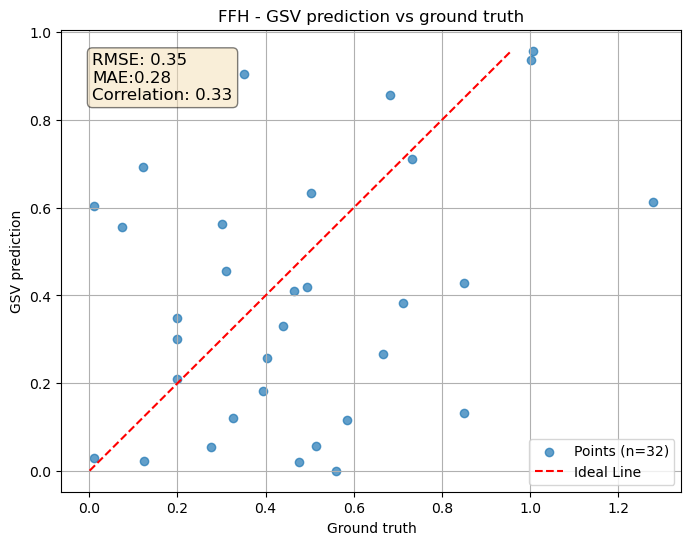

In [91]:
# filter out invalid prediction/groundtruth data
predicted_FFH=gdf_updated["FFH_GSV"]
gt_FFH=gdf_updated["Floor_height"]
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH)
# valid_indices = ~np.isnan(predicted_FFH) & ~np.isnan(gt_FFH) &(predicted_FFH!=0)& (gt_FFH!=0.28)
valid_indices = (predicted_FFH>0) & (predicted_FFH<1) & ~np.isnan(gt_FFH)& (gt_FFH!=0.28)
predicted_FFH = predicted_FFH[valid_indices]
gt_FFH = gt_FFH[valid_indices]

# Calculate RMSE and MAE
rmse = root_mean_squared_error(gt_FFH, predicted_FFH)
mae=mean_absolute_error(gt_FFH, predicted_FFH)
# Calculate Correlation Coefficient
correlation = np.corrcoef(gt_FFH, predicted_FFH)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFH, predicted_FFH, alpha=0.7, label=f'Points (n={len(predicted_FFH)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFH.min(), predicted_FFH.max()],[predicted_FFH.min(), predicted_FFH.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nMAE:{mae:.2f}\nCorrelation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

In [82]:
gdf_updated[valid_indices][['pano_id','Floor_height','FFH_GSV']]

,pano_id,Floor_height,FFH_GSV
21,8RHDm0iunrI5VkoaIHpcbQ,0.28,0.226438
93,LiqptiIiopgSQoBXE3T58w,0.28,1.677549
118,WlG1TTUwcInq0PlUf9hgRg,0.28,0.145356
119,WlG1TTUwcInq0PlUf9hgRg,0.28,0.145356
124,W6aqLfkjFD8URnge4j1ljQ,0.28,0.763922
...,...,...,...
3194,3N0AUk4o5HQAeTM9rHD4Iw,0.28,0.037149
3315,eFNta3sOQ45whlg8VZ0erQ,0.28,0.328198
3332,eFNta3sOQ45whlg8VZ0erQ,0.28,0.328198
3376,hiP8-RQ39RTSWq2JQlAGuA,0.28,0.121820


### FFE

In [ ]:
# filter out invalid prediction/groundtruth data
predicted_FFE=gdf_updated["FFE_GSV"]
gt_FFE=gdf_updated["Floor_Leve"]
valid_indices = ~np.isnan(predicted_FFE) & ~np.isnan(gt_FFE)
predicted_FFE = predicted_FFE[valid_indices]
gt_FFE = gt_FFE[valid_indices]

# Calculate RMSE and MAE
rmse_FFE = root_mean_squared_error(gt_FFE, predicted_FFE)
mae_FFE=mean_absolute_error(gt_FFE, predicted_FFE)
# Calculate Correlation Coefficient
correlation_FFE = np.corrcoef(gt_FFE, predicted_FFE)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt_FFE, predicted_FFE, alpha=0.7, label=f'Points (n={len(predicted_FFE)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted_FFE.min(), predicted_FFE.max()],[predicted_FFE.min(), predicted_FFE.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse_FFE:.2f}\nMAE:{mae_FFE:.2f}\nCorrelation: {correlation_FFE:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - GSV prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('GSV prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

In [ ]:
len(predicted_FFH)